# 7주차 실습_3

#### Denoising AE DSA
normal : lyingBack, lyingRigh

abnormal: sitting

train(noise O, noise X) / test (noise O)

noise train AE 훈련,
noise x test AE 예측

1. Linear AE
2. Non-linear AE
3. Denoising AE

In [120]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

In [121]:
df = pd.read_csv("C:/Project/DeepLearning/Data/DSA_features.csv")
df

,T_xacc_mean,T_xacc_max,T_xacc_min,T_xacc_var,T_xacc_std,T_xacc_skew,T_yacc_mean,T_yacc_max,T_yacc_min,T_yacc_var,...,LL_ymag_std,LL_ymag_skew,LL_zmag_mean,LL_zmag_max,LL_zmag_min,LL_zmag_var,LL_zmag_std,LL_zmag_skew,activity,people
0,7.975714,8.1605,7.6823,0.014395,0.119981,-0.023319,1.083150,1.1832,0.99744,0.002208,...,0.000792,0.177075,-0.057119,-0.054963,-0.059241,6.778722e-07,0.000823,0.036729,sitting,p1
1,7.978250,8.1763,7.8472,0.007551,0.086896,0.552416,1.140865,1.2129,1.05810,0.000784,...,0.000860,-0.286918,-0.057268,-0.054945,-0.059589,7.032302e-07,0.000839,0.347471,sitting,p1
2,7.970894,8.0860,7.8470,0.003092,0.055603,0.100538,1.140962,1.2128,1.07960,0.000508,...,0.000762,-0.134430,-0.057068,-0.054711,-0.059065,6.268222e-07,0.000792,0.045579,sitting,p1
3,7.938412,8.1083,7.6901,0.003763,0.061343,-0.231914,1.165260,1.3170,1.07870,0.002173,...,0.000735,0.021485,-0.056422,-0.053670,-0.058310,8.011245e-07,0.000895,0.240690,sitting,p1
4,7.908930,8.1305,7.8322,0.001741,0.041731,2.042285,1.187504,1.2574,1.09450,0.000662,...,0.000824,-0.148229,-0.055801,-0.053313,-0.057815,6.853423e-07,0.000828,0.258429,sitting,p1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9115,8.280854,34.1980,-2.9038,28.080803,5.299132,1.350075,-1.491537,11.2240,-11.65100,14.670334,...,0.200829,-0.040701,0.297666,0.708480,-0.117430,4.135451e-02,0.203358,-0.310022,basketBall,p8
9116,9.591118,51.6970,-3.4129,35.722025,5.976791,2.981144,0.086304,6.9951,-11.76400,5.329897,...,0.148745,-0.266377,0.224716,0.554670,-0.250950,3.355704e-02,0.183186,-0.736410,basketBall,p8
9117,9.599113,27.9300,-1.0765,48.850886,6.989341,0.449237,-0.728367,3.7801,-8.36910,5.683022,...,0.310748,-0.009505,-0.237786,0.088854,-0.477260,2.026107e-02,0.142341,0.668438,basketBall,p8
9118,9.692482,72.7820,-2.6734,59.378336,7.705734,4.491114,-0.582724,6.1216,-8.85710,4.162963,...,0.156493,0.050624,0.533023,0.677800,0.055941,1.356379e-02,0.116464,-1.482489,basketBall,p8


In [122]:
df.shape

(9120, 272)

In [123]:
df['activity'].value_counts()

activity
sitting                    480
walkingTreadmillIncline    480
jumping                    480
rowing                     480
cyclingVertical            480
cyclingHorizontal          480
crossTrainer               480
stepper                    480
runningTreadmill           480
walkingTreadmillFlat       480
standing                   480
walkingLot                 480
movingInElevator           480
standingInElevatorStill    480
decendingStairs            480
ascendingStairs            480
lyingRigh                  480
lyingBack                  480
basketBall                 480
Name: count, dtype: int64

## Denoising AE

### 1.DSA데이터에서 lyingRigh, lyingBack(normal), sitting(abnormal)만 남기기

In [124]:
df_filtered = df[df['activity'].isin(['sitting', 'lyingRigh', 'lyingBack'])]
df_filtered = df_filtered.drop('people', axis=1)
df_filtered.head()

,T_xacc_mean,T_xacc_max,T_xacc_min,T_xacc_var,T_xacc_std,T_xacc_skew,T_yacc_mean,T_yacc_max,T_yacc_min,T_yacc_var,...,LL_ymag_var,LL_ymag_std,LL_ymag_skew,LL_zmag_mean,LL_zmag_max,LL_zmag_min,LL_zmag_var,LL_zmag_std,LL_zmag_skew,activity
0,7.975714,8.1605,7.6823,0.014395,0.119981,-0.023319,1.083150,1.1832,0.99744,0.002208,...,6.267229e-07,0.000792,0.177075,-0.057119,-0.054963,-0.059241,6.778722e-07,0.000823,0.036729,sitting
1,7.978250,8.1763,7.8472,0.007551,0.086896,0.552416,1.140865,1.2129,1.05810,0.000784,...,7.403458e-07,0.000860,-0.286918,-0.057268,-0.054945,-0.059589,7.032302e-07,0.000839,0.347471,sitting
2,7.970894,8.0860,7.8470,0.003092,0.055603,0.100538,1.140962,1.2128,1.07960,0.000508,...,5.802523e-07,0.000762,-0.134430,-0.057068,-0.054711,-0.059065,6.268222e-07,0.000792,0.045579,sitting
3,7.938412,8.1083,7.6901,0.003763,0.061343,-0.231914,1.165260,1.3170,1.07870,0.002173,...,5.398837e-07,0.000735,0.021485,-0.056422,-0.053670,-0.058310,8.011245e-07,0.000895,0.240690,sitting
4,7.908930,8.1305,7.8322,0.001741,0.041731,2.042285,1.187504,1.2574,1.09450,0.000662,...,6.787533e-07,0.000824,-0.148229,-0.055801,-0.053313,-0.057815,6.853423e-07,0.000828,0.258429,sitting


In [125]:
from sklearn.preprocessing import LabelEncoder

# LabelEncoder 객체 생성
label_encoder = LabelEncoder()

# 'label' 컬럼을 숫자로 변환
df_filtered['activity'] = label_encoder.fit_transform(df_filtered['activity'])

df_filtered.head()

,T_xacc_mean,T_xacc_max,T_xacc_min,T_xacc_var,T_xacc_std,T_xacc_skew,T_yacc_mean,T_yacc_max,T_yacc_min,T_yacc_var,...,LL_ymag_var,LL_ymag_std,LL_ymag_skew,LL_zmag_mean,LL_zmag_max,LL_zmag_min,LL_zmag_var,LL_zmag_std,LL_zmag_skew,activity
0,7.975714,8.1605,7.6823,0.014395,0.119981,-0.023319,1.083150,1.1832,0.99744,0.002208,...,6.267229e-07,0.000792,0.177075,-0.057119,-0.054963,-0.059241,6.778722e-07,0.000823,0.036729,2
1,7.978250,8.1763,7.8472,0.007551,0.086896,0.552416,1.140865,1.2129,1.05810,0.000784,...,7.403458e-07,0.000860,-0.286918,-0.057268,-0.054945,-0.059589,7.032302e-07,0.000839,0.347471,2
2,7.970894,8.0860,7.8470,0.003092,0.055603,0.100538,1.140962,1.2128,1.07960,0.000508,...,5.802523e-07,0.000762,-0.134430,-0.057068,-0.054711,-0.059065,6.268222e-07,0.000792,0.045579,2
3,7.938412,8.1083,7.6901,0.003763,0.061343,-0.231914,1.165260,1.3170,1.07870,0.002173,...,5.398837e-07,0.000735,0.021485,-0.056422,-0.053670,-0.058310,8.011245e-07,0.000895,0.240690,2
4,7.908930,8.1305,7.8322,0.001741,0.041731,2.042285,1.187504,1.2574,1.09450,0.000662,...,6.787533e-07,0.000824,-0.148229,-0.055801,-0.053313,-0.057815,6.853423e-07,0.000828,0.258429,2


In [126]:
from sklearn.preprocessing import StandardScaler

# StandardScaler 객체 생성
scaler = StandardScaler()

# 열 이름의 접두사/접미사를 사용하여 필터링
prefixes = ['T_', 'RA_', 'LA_', 'RL_', 'LL_']  # 원하는 접두사 리스
columns_to_scale = df_filtered.columns[df_filtered.columns.str.startswith(tuple(prefixes))]

# 선택한 열을 스케일링
df_filtered[columns_to_scale] = scaler.fit_transform(df_filtered[columns_to_scale])

# 스케일링 후 데이터 확인
df_filtered.head()

,T_xacc_mean,T_xacc_max,T_xacc_min,T_xacc_var,T_xacc_std,T_xacc_skew,T_yacc_mean,T_yacc_max,T_yacc_min,T_yacc_var,...,LL_ymag_var,LL_ymag_std,LL_ymag_skew,LL_zmag_mean,LL_zmag_max,LL_zmag_min,LL_zmag_var,LL_zmag_std,LL_zmag_skew,activity
0,1.168376,1.179659,1.134716,0.424899,1.794701,-0.037407,1.064111,1.057739,1.076760,-0.084875,...,-0.135903,-0.337940,0.344190,0.054259,0.047582,0.061705,-0.137386,-0.365251,0.185769,2
1,1.168870,1.182732,1.166896,0.154077,1.031924,0.987842,1.078602,1.065174,1.092044,-0.152909,...,-0.135459,-0.325089,-0.608202,0.053994,0.047614,0.061085,-0.137190,-0.361128,0.826319,2
2,1.167436,1.165165,1.166857,-0.022360,0.310479,0.183152,1.078626,1.065149,1.097461,-0.166074,...,-0.136085,-0.343530,-0.295205,0.054349,0.048032,0.062019,-0.137782,-0.373792,0.204012,2
3,1.161106,1.169503,1.136238,0.004198,0.442800,-0.408865,1.084727,1.091232,1.097234,-0.086558,...,-0.136242,-0.348571,0.024825,0.055501,0.049890,0.063365,-0.136432,-0.345871,0.606205,2
4,1.155360,1.173822,1.163969,-0.075787,-0.009354,3.640945,1.090312,1.076313,1.101215,-0.158700,...,-0.135700,-0.331922,-0.323528,0.056609,0.050528,0.064247,-0.137329,-0.364029,0.642770,2


In [127]:
df_filtered['activity'].value_counts()

activity
2    480
0    480
1    480
Name: count, dtype: int64

#### label

0: lyingBack (normal)

1: lyingRigh (normal)

2: sitting (abnormal)

레이블을 두개로 줄여서 해보면,

0: lyingBack, lyingRigh (normal)

1: sitting (abnormal)

In [128]:
# activity가 0 또는 1인 경우 모두 0으로 통합
df_filtered.loc[df_filtered['activity'].isin([0, 1]), 'activity'] = 0
df_filtered.loc[df_filtered['activity'].isin([2]), 'activity'] = 1

In [129]:
df_filtered['activity'].value_counts()

activity
0    960
1    480
Name: count, dtype: int64

### 2. Noise Data

In [130]:
df_noised = df_filtered.copy()

noise_factor = np.random.uniform(0, 1)

# 노이즈를 추가할 열 이름의 접두사 설정
prefixes = ['T_', 'RA_', 'LA_', 'RL_', 'LL_']
columns_to_add_noise = df_noised.columns[df_noised.columns.str.startswith(tuple(prefixes))]

# 선택한 열에 노이즈 추가
for column in columns_to_add_noise:
    df_noised[column] += noise_factor * np.random.normal(loc=0.0, scale=1.0, size=df_noised[column].shape)

# 노이즈가 추가된 데이터 확인
df_noised

,T_xacc_mean,T_xacc_max,T_xacc_min,T_xacc_var,T_xacc_std,T_xacc_skew,T_yacc_mean,T_yacc_max,T_yacc_min,T_yacc_var,...,LL_ymag_var,LL_ymag_std,LL_ymag_skew,LL_zmag_mean,LL_zmag_max,LL_zmag_min,LL_zmag_var,LL_zmag_std,LL_zmag_skew,activity
0,1.239401,1.087526,0.842594,0.353612,1.994032,-0.283546,0.986912,1.146918,1.189425,-0.103498,...,-0.137869,-0.348562,0.321129,0.056001,0.108940,0.085274,-0.094292,-0.192198,0.125527,1
1,1.273809,1.284918,1.232501,0.226075,0.954294,1.257360,0.973312,0.975947,1.254198,-0.111786,...,0.058862,-0.399502,-0.825643,-0.024976,0.014460,-0.118674,-0.252800,-0.465957,0.470730,1
2,1.090238,1.245689,1.351449,0.140058,0.520903,0.118846,1.141506,1.104752,1.156327,-0.014685,...,0.028785,-0.366120,-0.268312,-0.090011,-0.081534,-0.134792,-0.111001,-0.402340,0.227403,1
3,1.081945,1.008997,1.277846,0.021939,0.656337,-0.220224,0.854408,0.857386,1.135315,-0.043213,...,-0.114846,-0.108294,-0.059685,-0.026007,0.116271,0.265235,-0.219650,-0.290728,0.652143,1
4,1.014675,1.223711,1.063776,0.121317,-0.074459,3.694762,0.777991,0.756275,1.239459,-0.245288,...,-0.118019,-0.067311,-0.317583,0.181102,0.111877,-0.087304,-0.116331,-0.398912,0.606758,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1915,0.039150,0.237535,0.132092,-0.107877,-0.582626,0.171721,-1.478974,-1.513098,-1.516445,-0.256352,...,0.128317,1.534086,0.892082,-0.691509,-0.415479,-0.838173,0.705628,1.986213,-1.194312,0
1916,-0.000693,0.074925,0.019964,-0.295277,-0.514311,0.463409,-1.778841,-1.621406,-1.586038,-0.304987,...,0.043413,1.255455,0.236606,-0.493668,-0.696749,-0.424578,0.324205,2.121542,2.092589,0
1917,0.100018,-0.209556,0.046540,-0.079611,-0.459206,-0.189655,-1.608727,-1.582028,-1.571226,-0.276856,...,0.068717,0.683509,-0.143579,-0.462036,-0.487630,-0.658232,0.194128,1.792776,1.031843,0
1918,0.301094,-0.090751,-0.051144,-0.058004,-0.380320,-0.158564,-1.603081,-1.561344,-1.613593,-0.150952,...,0.305612,1.182873,0.979911,-0.470314,-0.441024,-0.398201,0.719063,2.338998,2.816123,0


In [131]:
LABELS = ["Normal", "Abnormal"]

In [132]:
# activity가 0 또는 1인 데이터를 선택
# normal = df_filtered[(df_filtered.activity == 0) | (df_filtered.activity == 1)]

normal = df_filtered[(df_noised.activity == 0)]

# activity가 1인 데이터를 선택
abnormal = df_filtered[df_noised.activity == 1]

# normal 데이터프레임의 모양 확인
normal.shape

(960, 271)

In [133]:
abnormal.shape

(480, 271)

### 2. Noisiy Data train test split

In [134]:
from sklearn.model_selection import train_test_split

X_noisy_train, X_noisy_test = train_test_split(df_noised, test_size=0.25, random_state=20)

X_train.head()

,T_xacc_mean,T_xacc_max,T_xacc_min,T_xacc_var,T_xacc_std,T_xacc_skew,T_yacc_mean,T_yacc_max,T_yacc_min,T_yacc_var,...,LL_ymag_var,LL_ymag_std,LL_ymag_skew,LL_zmag_mean,LL_zmag_max,LL_zmag_min,LL_zmag_var,LL_zmag_std,LL_zmag_skew,activity
1010,-1.327066,-1.263035,-1.152336,-0.016296,0.245348,1.170603,0.665611,0.701034,0.753364,-0.283374,...,-0.035550,-0.022476,-0.258795,-0.868227,-0.833110,-0.571547,-0.129907,-0.204759,0.607982,0
1467,0.008860,-0.053742,-0.012192,-0.071846,-0.248836,-0.131350,-1.399446,-1.118919,-1.289619,-0.049312,...,0.055015,-0.235188,0.216407,-0.523513,-0.466483,-0.680959,-0.136773,-0.376569,0.492545,0
388,1.224233,1.428389,1.323486,0.127738,0.209297,1.255185,0.472347,0.390717,0.372355,0.042481,...,-0.191768,-0.180283,0.438933,1.586209,1.243395,1.521174,-0.185107,-0.302012,0.083396,1
6,1.409651,1.088468,1.460524,-0.179922,-0.059889,1.269057,1.234702,1.017191,1.122960,0.045740,...,-0.043465,-0.485825,-0.228579,0.189081,-0.072194,0.219072,-0.412087,-0.351659,-0.130707,1
370,1.139645,1.263937,1.598646,0.016120,-0.090444,0.432263,0.461585,0.230198,0.348127,-0.050020,...,-0.022189,-0.438948,-0.278199,1.369850,1.438740,1.413805,0.056944,-0.251738,0.369877,1


In [135]:
X_train.shape, X_test.shape

((1080, 271), (360, 271))

### 3. Validation data without noisy

In [136]:
from sklearn.model_selection import train_test_split

X_pure_train, X_pure_test = train_test_split(df_filtered, test_size=0.25, random_state=20)

X_train.head()

,T_xacc_mean,T_xacc_max,T_xacc_min,T_xacc_var,T_xacc_std,T_xacc_skew,T_yacc_mean,T_yacc_max,T_yacc_min,T_yacc_var,...,LL_ymag_var,LL_ymag_std,LL_ymag_skew,LL_zmag_mean,LL_zmag_max,LL_zmag_min,LL_zmag_var,LL_zmag_std,LL_zmag_skew,activity
1010,-1.327066,-1.263035,-1.152336,-0.016296,0.245348,1.170603,0.665611,0.701034,0.753364,-0.283374,...,-0.035550,-0.022476,-0.258795,-0.868227,-0.833110,-0.571547,-0.129907,-0.204759,0.607982,0
1467,0.008860,-0.053742,-0.012192,-0.071846,-0.248836,-0.131350,-1.399446,-1.118919,-1.289619,-0.049312,...,0.055015,-0.235188,0.216407,-0.523513,-0.466483,-0.680959,-0.136773,-0.376569,0.492545,0
388,1.224233,1.428389,1.323486,0.127738,0.209297,1.255185,0.472347,0.390717,0.372355,0.042481,...,-0.191768,-0.180283,0.438933,1.586209,1.243395,1.521174,-0.185107,-0.302012,0.083396,1
6,1.409651,1.088468,1.460524,-0.179922,-0.059889,1.269057,1.234702,1.017191,1.122960,0.045740,...,-0.043465,-0.485825,-0.228579,0.189081,-0.072194,0.219072,-0.412087,-0.351659,-0.130707,1
370,1.139645,1.263937,1.598646,0.016120,-0.090444,0.432263,0.461585,0.230198,0.348127,-0.050020,...,-0.022189,-0.438948,-0.278199,1.369850,1.438740,1.413805,0.056944,-0.251738,0.369877,1


### 4. train/valid에서 sitting 데이터 삭제 (abnormal 삭제)

In [137]:
# normal feature만 가지는 X_train, X_valid
X_noisy_train = X_noisy_train[X_noisy_train.activity == 1]
X_pure_train = X_pure_train[X_pure_train.activity == 1]

y_noisy_train = X_noisy_train['activity']
y_pure_train = X_pure_train['activity']

X_noisy_train = X_noisy_train.drop(['activity'], axis=1)
X_pure_train = X_pure_train.drop(['activity'], axis=1)

X_noisy_train

,T_xacc_mean,T_xacc_max,T_xacc_min,T_xacc_var,T_xacc_std,T_xacc_skew,T_yacc_mean,T_yacc_max,T_yacc_min,T_yacc_var,...,LL_ymag_min,LL_ymag_var,LL_ymag_std,LL_ymag_skew,LL_zmag_mean,LL_zmag_max,LL_zmag_min,LL_zmag_var,LL_zmag_std,LL_zmag_skew
388,1.269272,1.088892,1.314948,-0.149112,0.183098,0.991912,0.476139,0.287663,0.416334,-0.111910,...,0.187202,-0.143800,-0.290425,0.531820,1.354316,1.264871,1.475108,-0.163121,-0.433892,-0.003269
6,1.177516,0.841656,1.282924,0.168104,0.182016,1.601498,1.173417,1.008046,0.963276,-0.234087,...,0.141180,-0.140777,-0.238986,0.120055,0.005033,-0.341789,0.080688,-0.251192,-0.243860,0.100657
370,1.350199,1.447545,1.409491,0.050206,-0.137860,0.478695,0.247821,0.453091,0.326594,-0.099324,...,0.362609,-0.142443,-0.108369,-0.298011,1.421614,1.308438,1.349958,-0.187553,-0.792378,0.559939
275,1.008037,0.845991,0.949445,0.011857,-0.052276,0.347952,0.772126,0.618780,0.937737,-0.112574,...,1.058844,-0.046004,-0.271936,0.503208,0.851361,0.652189,0.690912,-0.129872,-0.334269,-0.234891
337,1.117608,1.223700,1.121557,0.729626,2.467657,1.935227,0.978143,0.862042,0.780292,0.003373,...,0.795948,-0.228070,-0.234784,-0.711271,0.459027,0.538044,0.643302,-0.293871,-0.264881,0.133252
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,1.522005,1.408722,1.492525,-0.212295,-0.265532,-0.035918,0.374720,0.356094,0.342342,-0.203104,...,0.230729,-0.077358,-0.265057,0.867109,0.940972,0.988849,1.173247,-0.191605,-0.432878,0.044524
282,1.041734,1.110018,0.880825,-0.269588,-0.507738,-1.521100,0.582968,0.656505,0.601495,-0.136969,...,0.741162,-0.318305,-0.210363,0.705204,0.941892,0.841903,0.786684,-0.231269,-0.481708,-0.420027
393,1.326449,1.351657,1.199075,-0.070803,-0.189070,0.490237,0.111846,0.241920,0.376778,-0.435721,...,0.526304,-0.094831,-0.223937,-0.807732,1.389200,1.378177,1.402889,-0.335788,-0.210456,-0.096319
271,0.844843,0.878564,1.173007,-0.118436,0.172432,-1.166793,0.953444,0.663938,0.518402,0.037975,...,1.033261,-0.401475,-0.272835,0.543372,0.383914,0.600790,0.565943,-0.024988,-0.421754,0.473402


In [138]:
y_noisy_test = X_noisy_test['activity']
X_noisy_test = X_noisy_test.drop(['activity'], axis=1)

X_noisy_test

,T_xacc_mean,T_xacc_max,T_xacc_min,T_xacc_var,T_xacc_std,T_xacc_skew,T_yacc_mean,T_yacc_max,T_yacc_min,T_yacc_var,...,LL_ymag_min,LL_ymag_var,LL_ymag_std,LL_ymag_skew,LL_zmag_mean,LL_zmag_max,LL_zmag_min,LL_zmag_var,LL_zmag_std,LL_zmag_skew
1107,-0.962004,-0.951186,-1.037171,-0.185364,-0.333962,0.760731,0.710294,0.805326,0.848193,-0.062437,...,-0.234778,0.150944,-0.353340,0.294398,2.044669,1.868316,1.881568,-0.458233,-0.386396,0.029969
1383,-0.661356,-0.654536,-0.674534,0.172130,-0.221403,-1.438927,0.179121,-0.009184,0.138347,-0.051087,...,0.155428,0.336543,0.889150,1.726714,-1.075270,-1.027922,-0.965926,0.247170,1.552512,-3.619777
1231,-1.154922,-1.162024,-1.028102,-0.083205,0.726930,0.149090,0.689566,0.877282,0.577072,-0.217019,...,-0.226151,-0.184979,-0.388251,0.570204,1.140649,1.411204,1.291662,-0.184603,-0.244079,-0.082359
420,1.105678,1.041496,1.063197,-0.200790,-0.517422,-0.463015,0.743888,0.646451,0.675830,-0.045907,...,-0.657177,0.190154,1.261572,-0.517340,1.195035,0.941801,0.922914,0.565767,1.395483,1.100286
321,1.218663,1.212718,1.285127,0.209655,0.302701,0.836795,0.845098,0.689515,0.789422,-0.092962,...,0.906428,-0.170124,-0.251301,0.119325,0.359135,0.214739,0.436093,-0.016894,-0.231731,-0.508174
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1089,-1.103864,-1.323110,-0.760124,0.140415,-0.048227,-0.080808,0.949592,0.665633,0.752035,-0.236478,...,-0.263447,-0.012064,-0.446929,0.359280,1.819679,1.906927,1.823775,-0.126164,-0.367482,0.613929
398,1.343831,1.537529,1.490828,-0.207146,0.033515,0.717879,0.220112,0.160276,0.333469,-0.052341,...,0.217628,-0.289123,-0.495915,0.294340,1.339198,1.538853,1.375300,-0.376333,-0.388928,-0.358554
1454,0.096745,0.001530,-0.013537,-0.189235,-0.244900,0.096823,-1.235743,-1.007865,-1.371797,-0.260687,...,0.648929,-0.350546,-0.157740,-0.119826,-0.612880,-0.601753,-0.509827,-0.086058,-0.447227,-0.307290
18,1.440396,1.103938,1.297571,0.119291,0.191141,0.261194,1.187965,1.029293,1.214825,-0.001983,...,0.048905,-0.345135,-0.251883,-0.698700,-0.012241,0.078114,0.184348,-0.488923,-0.501525,1.367560


In [139]:
# X_train과 X_test를 넘파이 배열로 변환
X_noisy_train = X_noisy_train.values
X_noisy_test = X_noisy_test.values

X_noisy_train

array([[ 1.26927244,  1.08889209,  1.31494755, ..., -0.16312118,
        -0.43389197, -0.00326885],
       [ 1.17751586,  0.84165561,  1.28292449, ..., -0.25119207,
        -0.24386038,  0.10065716],
       [ 1.35019947,  1.44754522,  1.40949069, ..., -0.18755286,
        -0.79237763,  0.55993862],
       ...,
       [ 1.32644921,  1.35165745,  1.19907472, ..., -0.3357883 ,
        -0.21045613, -0.09631928],
       [ 0.84484288,  0.87856396,  1.17300651, ..., -0.02498796,
        -0.42175364,  0.47340174],
       [ 1.26996721,  1.27924867,  1.44395343, ...,  0.69742351,
         2.00172905,  1.04445895]])

In [153]:
import numpy as np
from sklearn.utils import shuffle

X_combined = np.vstack((X_noisy_train, X_pure_train))  # 데이터 합치기
y_combined = np.concatenate((y_noisy_train, y_pure_train))  # 기존 레이블 합치기

X_combined, y_combined = shuffle(X_combined, y_combined, random_state=42)

# 섞인 데이터 확인
X_combined.shape

(704, 270)

In [154]:
y_combined.shape # 섞인 레이블의 크기

(704,)

### 4. AE로 Noisy Train & Pure Train 데이터로 모델 학습 (Pure 데이터로 검증)

In [155]:
# 오토인코더 모델

input_dim = X_combined.shape[1]
encoding_dim = 16  # 인코딩 차원을 설정 (임의로 설정한 값, 조정 가능)

input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(input_layer)
encoded = Dense(int(encoding_dim / 2), activation='relu')(encoded)
decoded = Dense(int(encoding_dim /2), activation='relu')(encoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
autoencoder.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 270)]             0         
                                                                 
 dense_36 (Dense)            (None, 16)                4336      
                                                                 
 dense_37 (Dense)            (None, 8)                 136       
                                                                 
 dense_38 (Dense)            (None, 8)                 72        
                                                                 
 dense_39 (Dense)            (None, 270)               2430      
                                                                 
Total params: 6974 (27.24 KB)
Trainable params: 6974 (27.24 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [156]:
# 모델 학습
history = autoencoder.fit(X_combined, y_combined, epochs=50, batch_size=256, shuffle=True, validation_data=(X_pure_train, y_pure_train))

Epoch 1/50
3/3 [==============================] - 1s 116ms/step - loss: 0.2497 - val_loss: 0.2483
Epoch 2/50
3/3 [==============================] - 0s 21ms/step - loss: 0.2477 - val_loss: 0.2463
Epoch 3/50
3/3 [==============================] - 0s 23ms/step - loss: 0.2455 - val_loss: 0.2436
Epoch 4/50
3/3 [==============================] - 0s 22ms/step - loss: 0.2427 - val_loss: 0.2403
Epoch 5/50
3/3 [==============================] - 0s 20ms/step - loss: 0.2391 - val_loss: 0.2360
Epoch 6/50
3/3 [==============================] - 0s 21ms/step - loss: 0.2344 - val_loss: 0.2306
Epoch 7/50
3/3 [==============================] - 0s 21ms/step - loss: 0.2286 - val_loss: 0.2238
Epoch 8/50
3/3 [==============================] - 0s 21ms/step - loss: 0.2214 - val_loss: 0.2155
Epoch 9/50
3/3 [==============================] - 0s 22ms/step - loss: 0.2126 - val_loss: 0.2056
Epoch 10/50
3/3 [==============================] - 0s 22ms/step - loss: 0.2022 - val_loss: 0.1940
Epoch 11/50
3/3 [===========

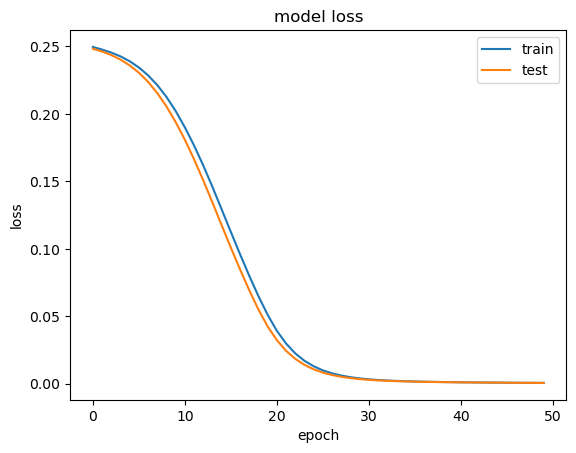

In [157]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

### Noisy 데이터로 AE 예측

In [164]:
# X_noisy_test 값을 넣어서 Reconstruction Error 값을 얻고,
# 실제 레이블인 y_noisy_test와 데이터프레임으로 구성
# Reconstruction Error + 실제 레이블의 형태가 됨

predictions = autoencoder.predict(X_noisy_test)
mse = np.mean(np.power(X_noisy_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_noisy_test})
error_df.describe()

12/12 [==============================] - 0s 2ms/step


,reconstruction_error,true_class
count,360.000000,360.000000
mean,1.642057,0.355556
std,3.676954,0.479348
min,0.587726,0.000000
25%,0.955381,0.000000
50%,1.186807,0.000000
75%,1.469663,1.000000
max,60.944096,1.000000


In [159]:
error_df = error_df.reset_index(drop=True)
error_df

,reconstruction_error,true_class
0,1.149348,0
1,0.807929,0
2,1.195682,0
3,1.705072,1
4,1.397309,1
...,...,...
355,1.159444,0
356,1.668267,1
357,0.868151,0
358,1.482171,1


In [161]:
threshold = 0.955381

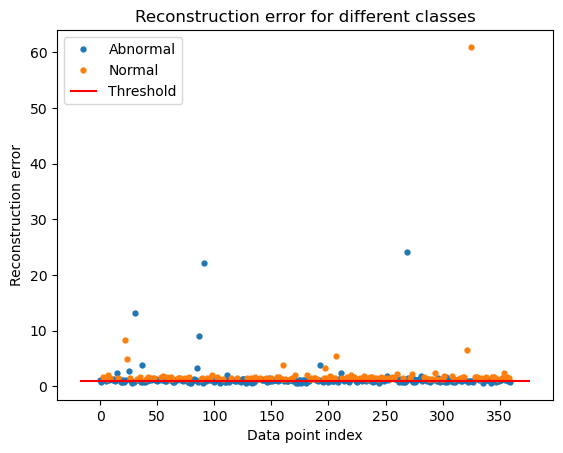

In [162]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Normal" if name == 1 else "Abnormal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

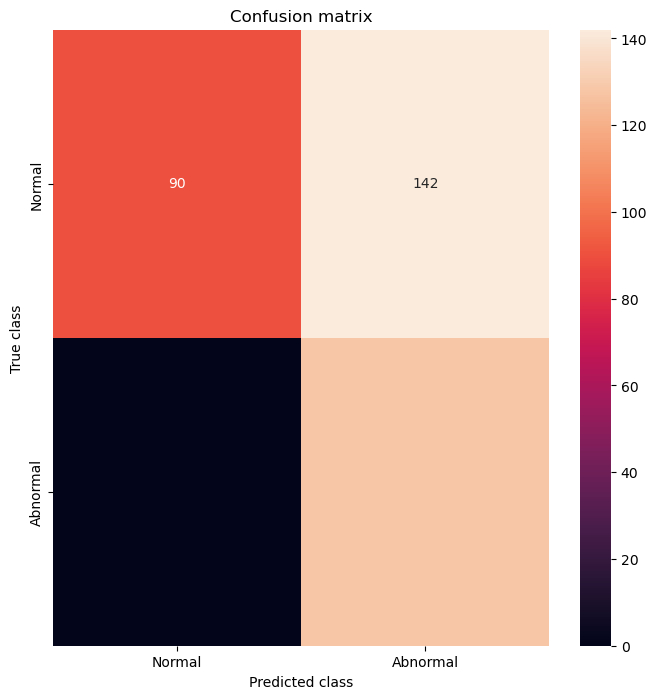

              precision    recall  f1-score   support

           0       1.00      0.39      0.56       232
           1       0.47      1.00      0.64       128

    accuracy                           0.61       360
   macro avg       0.74      0.69      0.60       360
weighted avg       0.81      0.61      0.59       360



In [163]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

print(classification_report(error_df.true_class, y_pred))